In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


In [18]:
util.startLoop()

In [19]:
# Conectar con Interactive Brokers
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [20]:
# Definir contrato de la acción COIN
contract = Stock('COIN', 'SMART', 'USD')


In [21]:
# Obtener datos históricos
bars = ib.reqHistoricalData(
    contract,
    endDateTime='',
    durationStr='60 D',
    barSizeSetting='1 day',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

In [22]:
# Convertir a DataFrame
df = pd.DataFrame(bars)
df['Fecha'] = pd.to_datetime(df['date'])
df['Precio'] = df['close']

In [23]:
# Normalizar datos
scaler = MinMaxScaler()
df['Precio_Normalizado'] = scaler.fit_transform(df[['Precio']])


In [24]:
# Crear secuencias de datos para LSTM
def create_sequences(data, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # Usamos los últimos 10 días para predecir el siguiente
X, y = create_sequences(df['Precio_Normalizado'].values, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [25]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Entrenar el modelo
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2505
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0520 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

In [27]:
# Hacer predicción
last_sequence = df['Precio_Normalizado'].values[-seq_length:]
last_sequence = last_sequence.reshape(1, seq_length, 1)
prediction = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(prediction.reshape(-1, 1))[0][0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


In [28]:
# Definir punto máximo y mínimo
max_price = df['Precio'].max()
min_price = df['Precio'].min()
diff = max_price - min_price

In [29]:
# Niveles de Fibonacci
fibonacci_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
fib_lines = [max_price - diff * level for level in fibonacci_levels]

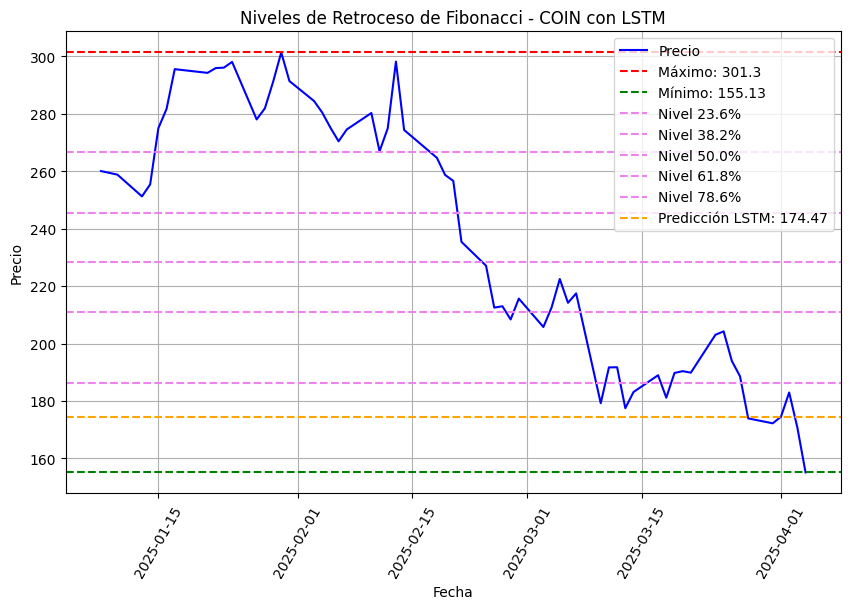

In [30]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df['Fecha'], df['Precio'], label='Precio', color='blue')
plt.axhline(y=max_price, linestyle='--', color='red', label=f'Máximo: {max_price}')
plt.axhline(y=min_price, linestyle='--', color='green', label=f'Mínimo: {min_price}')
plt.xticks( rotation = 60 )

# Dibujar líneas de Fibonacci
for level, line in zip(fibonacci_levels, fib_lines):
    plt.axhline(y=line, linestyle='--', color='violet', label=f'Nivel {level*100:.1f}%')

# Dibujar predicción LSTM
plt.axhline(y=predicted_price, linestyle='--', color='orange', label=f'Predicción LSTM: {predicted_price:.2f}')

plt.legend()
plt.title('Niveles de Retroceso de Fibonacci - COIN con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid()
plt.show()

In [16]:
ib.disconnect()